In [24]:
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import optimizers, regularizers, Model
from keras.applications import densenet

from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd
import pickle
import os
from os import listdir
from os.path import isfile, join 
import cv2

### Model Setting

In [4]:
IMAGE_SIZE = (256,256)
INPUT_SHAPE = (256,256,3)

BATCH_SIZE = 12
EPOCHS = 20
STEP_PER_EPOCHS = 50

### Read Image Dataset

In [5]:
base_dir = 'dataset_v2'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
predict_dir = os.path.join(base_dir, 'predict')

### Creating objects for image augmentations

In [6]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            vertical_flip=True,
                            rotation_range=30,
                            width_shift_range=0.3,
                            height_shift_range=0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                    target_size=IMAGE_SIZE,
                                    batch_size=BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(test_dir,
                                    target_size=IMAGE_SIZE,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False)

Found 1890 images belonging to 5 classes.
Found 418 images belonging to 5 classes.


### Load DenseNet121 model with ImageNet weights

In [7]:
# imports the pretrained model and discards the fc layer
base_model = densenet.DenseNet121(include_top=False,weights='imagenet',
                           input_tensor=None,input_shape=INPUT_SHAPE,pooling='max')

In [8]:
x = base_model.output

x = BatchNormalization()(x)
x = Dense(1024, activation="relu")(x)

predictions = Dense(5, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
# Compiling the model
optimizer = optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Fit Model

In [10]:
STEP_PER_EPOCHS = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = test_generator.n//test_generator.batch_size

model_history = model.fit(train_generator,
                steps_per_epoch=STEP_PER_EPOCHS, epochs=EPOCHS,
                validation_data=test_generator, validation_steps=STEP_SIZE_VALID,
                callbacks=[EarlyStopping(monitor='loss',patience=3,verbose=1)])

Epoch 1/20
157/157 [==============================] - 1392s 9s/step - loss: 1.3187 - accuracy: 0.4691 - val_loss: 1.0958 - val_accuracy: 0.6054
Epoch 2/20
157/157 [==============================] - 2031s 13s/step - loss: 0.9218 - accuracy: 0.6683 - val_loss: 0.7534 - val_accuracy: 0.7451
Epoch 3/20
157/157 [==============================] - 2077s 13s/step - loss: 0.7220 - accuracy: 0.7476 - val_loss: 0.5641 - val_accuracy: 0.8088
Epoch 4/20
157/157 [==============================] - 1618s 10s/step - loss: 0.6306 - accuracy: 0.7854 - val_loss: 0.4884 - val_accuracy: 0.8480
Epoch 5/20
157/157 [==============================] - 1299s 8s/step - loss: 0.5362 - accuracy: 0.8216 - val_loss: 0.4174 - val_accuracy: 0.8676
Epoch 6/20
157/157 [==============================] - 1266s 8s/step - loss: 0.4915 - accuracy: 0.8365 - val_loss: 0.3913 - val_accuracy: 0.8652
Epoch 7/20
157/157 [==============================] - 1389s 9s/step - loss: 0.4689 - accuracy: 0.8403 - val_loss: 0.3682 - val_accura

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv4_block6_0_relu (Activation (None, 16, 16, 416)  0           conv4_block6_0_bn[0][0]          
__________________________________________________________________________________________________
conv4_block6_1_conv (Conv2D)    (None, 16, 16, 128)  53248       conv4_block6_0_relu[0][0]        
__________________________________________________________________________________________________
conv4_block6_1_bn (BatchNormali (None, 16, 16, 128)  512         conv4_block6_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block6_1_relu (Activation (None, 16, 16, 128)  0           conv4_block6_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block6_2_conv (Conv2D)    (None, 16, 16, 32)   36864       conv4_block6_1_relu[0][0]        
__________

Total params: 8,096,325
Trainable params: 8,010,629
Non-trainable params: 85,696
__________________________________________________________________________________________________


### Model Accuracy and Loss Plots

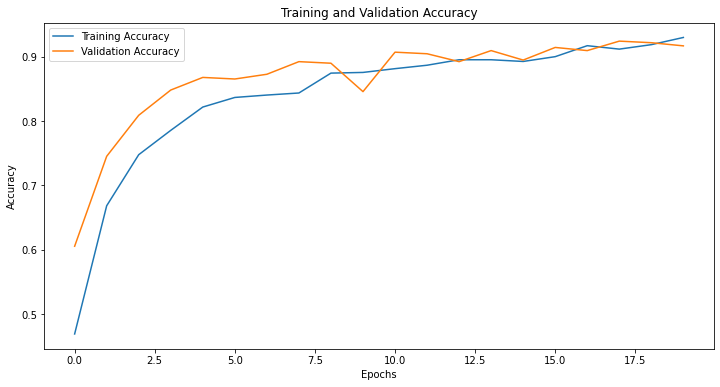

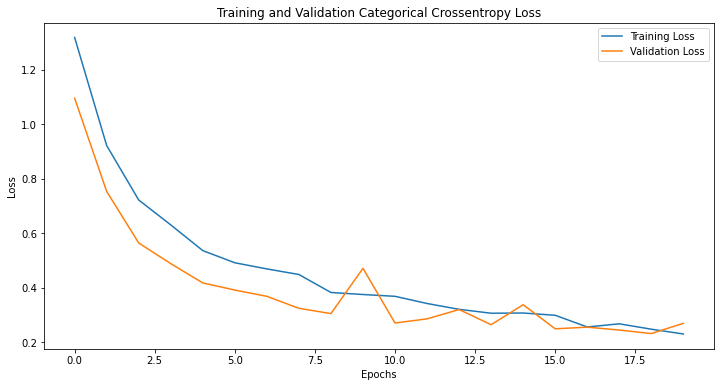

In [12]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

def model_performance_plot(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Training Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation Accuracy')
    plt.legend()
  

    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and Validation Categorical Crossentropy Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Training Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


model_performance_plot(model_history)

### Evaluate Test Dataset

In [30]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//test_generator.batch_size)

34/34 [==============================] - 59s 2s/step - loss: 0.2691 - accuracy: 0.9167


In [14]:
print("Test dataset Accuracy: %f and Loss: %f" % (accuracy,loss))

Test dataset Accuracy: 0.916667 and Loss: 0.269128


### Model Classification and Confusion Matrix

In [15]:
Y_pred = model.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [16]:
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))    

              precision    recall  f1-score   support

   cardboard       0.95      0.95      0.95       101
       glass       0.92      0.86      0.89        80
       metal       0.79      1.00      0.88        65
       paper       0.93      0.95      0.94        95
     plastic       0.97      0.79      0.87        77

    accuracy                           0.91       418
   macro avg       0.91      0.91      0.91       418
weighted avg       0.92      0.91      0.91       418



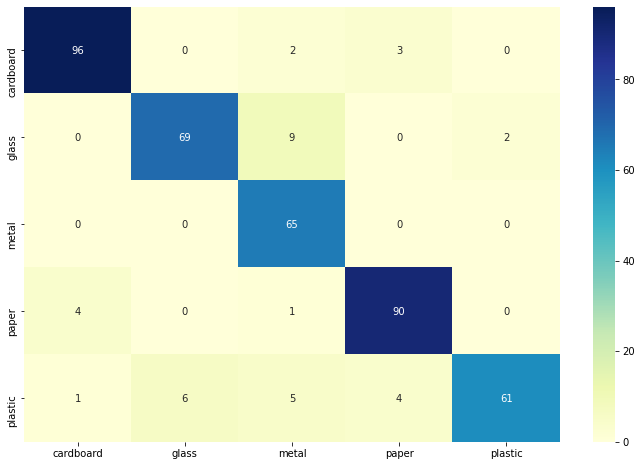

In [17]:
conf_mat = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(conf_mat, index = target_names, columns = target_names)
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

### Predict New image

In [18]:
class_mapping = {v:k for k,v in train_generator.class_indices.items()}

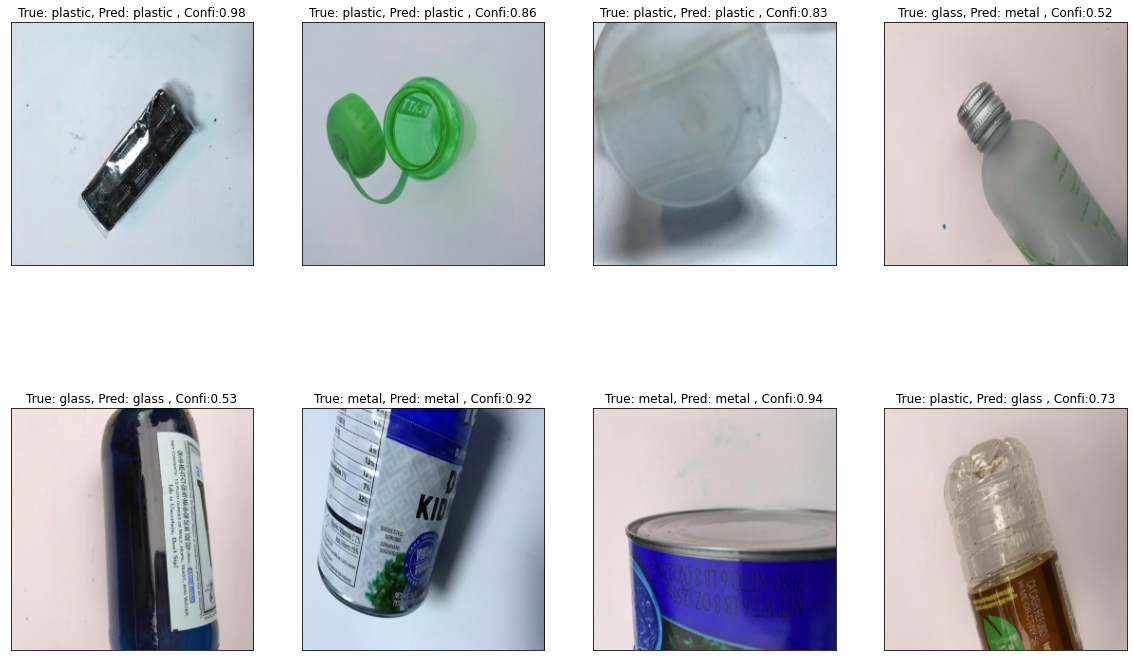

In [25]:
def image_type(filename):
    
    if "glass" in filename:
        return 'glass'
    elif "metal" in filename:
        return 'metal'
    elif "paper" in filename:
        return 'paper'
    elif "plastic" in filename:
        return 'plastic'
    elif "cardboard" in filename:
        return 'cardboard'
    

def plot_predicted_label(nrows, ncols,onlyfiles):
    fig, axes = plt.subplots(nrows, ncols,figsize=(20, 13))
    
    rs = np.random.choice(len(onlyfiles),nrows*ncols,replace=False)
    
    for i, ax in zip(rs, axes.flat):
        img = cv2.imread(os.path.join(predict_dir, onlyfiles[i]))
        true_type = image_type(onlyfiles[i])
        img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1])) 
        img = img /255
         
        probabilities = model.predict(np.asarray([img]))[0]
        class_idx = np.argmax(probabilities)
            
        title = 'True: %s, Pred: %s , Confi:%0.2f' % (true_type,class_mapping[class_idx],probabilities[class_idx])
        ax.imshow(img, cmap='binary')
        ax.set_title(title)
         
        ax.set_xticks([])
        ax.set_yticks([])
        
num_rows = 2
num_cols = 4

# load image path to predict
onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]

plot_predicted_label(num_rows, num_cols,onlyfiles);

### Save Model

In [33]:
model.save('DenseNet121.h5')